In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from itertools import product
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

Sequential = tf.keras.Sequential
SimpleRNN = tf.keras.layers.SimpleRNN
LSTM = tf.keras.layers.LSTM
GRU = tf.keras.layers.GRU
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
Adam = tf.keras.optimizers.Adam
callbacks = tf.keras.callbacks
EarlyStopping = callbacks.EarlyStopping

### 1. Loading data,scaling and sequences

        Date       Low      Open     Volume      High     Close  \
0 2004-08-19  2.390042  2.490664  897427216  2.591785  2.499133   
1 2004-08-20  2.503118  2.515820  458857488  2.716817  2.697639   
2 2004-08-23  2.716070  2.758411  366857939  2.826406  2.724787   
3 2004-08-24  2.579581  2.770615  306396159  2.779581  2.611960   
4 2004-08-25  2.587302  2.614201  184645512  2.689918  2.640104   

   Adjusted Close  
0        2.499133  
1        2.697639  
2        2.724787  
3        2.611960  
4        2.640104  


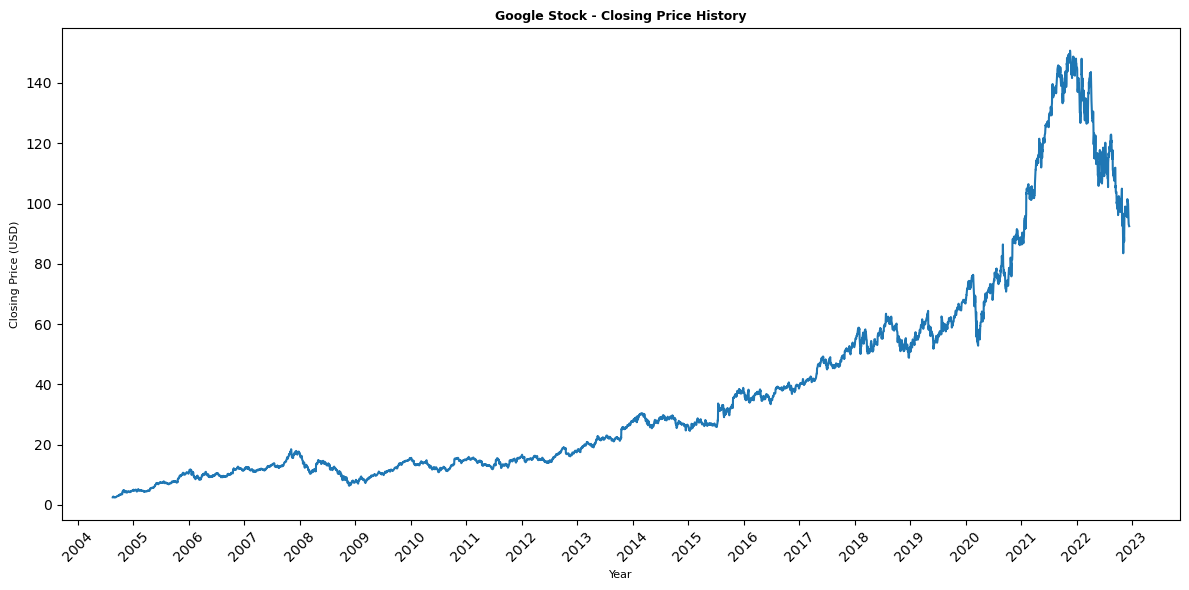

In [2]:
file_path = "./GOOG.csv"  
data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
dates = data['Date']

# Display the first few rows of the dataset
print(data.head())

import matplotlib.dates as mdates

# Data visualization: Plotting the closing price 
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Closing Price')
plt.xlabel('Year',fontsize=8)
plt.ylabel('Closing Price (USD)',fontsize=8)
plt.title('Google Stock - Closing Price History',fontsize=9,weight='bold')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Set major ticks every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format date labels to show year
plt.tight_layout()
plt.savefig('history.png', dpi=300, bbox_inches='tight')
plt.show()

In [3]:
# Check for missing values
print(data.isnull().sum())

Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64


In [4]:
# Features we can use for modeling
features = ['Open', 'High', 'Low', 'Close', 'Volume']

#Using selected features for modeling
data_for_model = data[features]
print(data_for_model.head())

# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_for_model)

import random

# Setting a random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Defining a function to create input sequences for RNN
def create_sequences(data, time_step=30):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])  # Past 'time_step' days as input
        y.append(data[i])  # Predict all features (Open, High, Low, Close, Volume)
    return np.array(X), np.array(y)

# Creating input sequences for training, validation, and test
time_step = 30
X, y = create_sequences(scaled_data, time_step)

# Split into train, validation, and test sets
train_size = int(0.70 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Keep corresponding dates for validation and test sets
dates_val = dates[train_size:train_size + val_size]
dates_test = dates[train_size + val_size:]

print(f"Training Set Shape: {X_train.shape}")
print(f"Validation Set Shape: {X_val.shape}")
print(f"Test Set Shape: {X_test.shape}")

       Open      High       Low     Close     Volume
0  2.490664  2.591785  2.390042  2.499133  897427216
1  2.515820  2.716817  2.503118  2.697639  458857488
2  2.758411  2.826406  2.716070  2.724787  366857939
3  2.770615  2.779581  2.579581  2.611960  306396159
4  2.614201  2.689918  2.587302  2.640104  184645512
Training Set Shape: (3207, 30, 5)
Validation Set Shape: (687, 30, 5)
Test Set Shape: (688, 30, 5)


### 2. Baseline model - Vanilla RNN

In [5]:
# Defining the RNN model
rnn_model = Sequential()

# Adding an input layer
rnn_model.add(tf.keras.Input(shape=(time_step, X_train.shape[2])))

# Adding an RNN layer with 20 units
rnn_model.add(SimpleRNN(20, activation='tanh', return_sequences=False))

# Adding a Dropout layer for regularization
rnn_model.add(Dropout(0.2))

# Adding a Dense output layer
rnn_model.add(Dense(X_train.shape[2]))  # Predicting all features

# Compiling the model
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
rnn_model.summary()

# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping],verbose=1)

# Predict on the validation set
y_val_pred_rnn = rnn_model.predict(X_val)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20)             │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 625 (2.44 KB)

 Trainable params: 625 (2.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0536 - val_loss: 0.0275
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0055 - val_loss: 0.0161
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035 - val_loss: 0.0107
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - val_loss: 0.0084
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021 - val_loss: 0.0065
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 - val_loss: 0.0061
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017 - val_loss: 0.0048
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 12/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [6]:
# Evaluate the model with performance metrics for each feature
for i, feature in enumerate(features):
    mae = mean_absolute_error(y_val[:, i], y_val_pred_rnn[:, i])
    mse = np.mean((y_val[:, i] - y_val_pred_rnn[:, i])**2)
    rmse = mse ** 0.5
    print(f"Vanilla RNN Validation Metrics for {feature}:")
    print(f"  MAE: {mae}")
    print(f"  RMSE: {rmse}")

Vanilla RNN Validation Metrics for Open:
  MAE: 0.007044628027877278
  RMSE: 0.009962202492617419
Vanilla RNN Validation Metrics for High:
  MAE: 0.006117543086400487
  RMSE: 0.007950747207810676
Vanilla RNN Validation Metrics for Low:
  MAE: 0.014754465865489228
  RMSE: 0.017218635104141677
Vanilla RNN Validation Metrics for Close:
  MAE: 0.009941675679141428
  RMSE: 0.011985980680491925
Vanilla RNN Validation Metrics for Volume:
  MAE: 0.010903191110562503
  RMSE: 0.014340416078214777


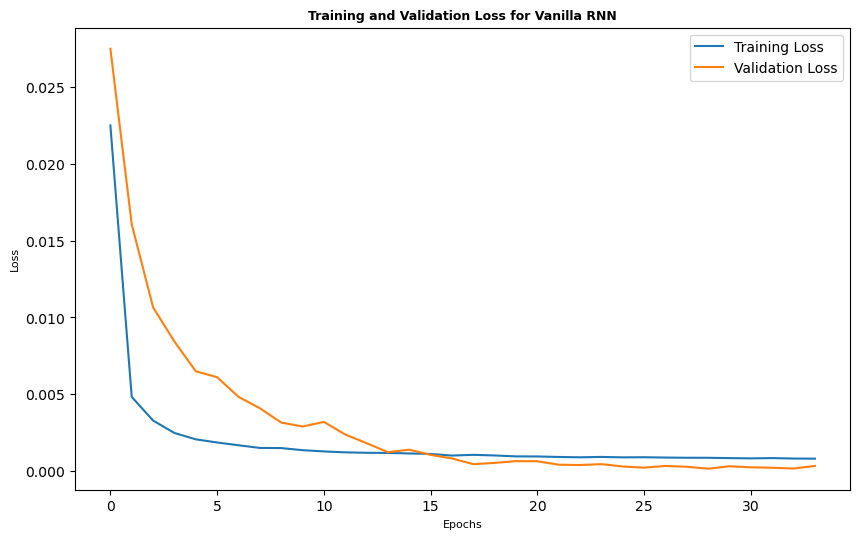

In [7]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs',fontsize=8)
plt.ylabel('Loss',fontsize=8)
plt.title('Training and Validation Loss for Vanilla RNN',fontsize=9,weight='bold')
plt.legend()
plt.savefig('Loss_Vanilla.png', dpi=300, bbox_inches='tight')
plt.show()

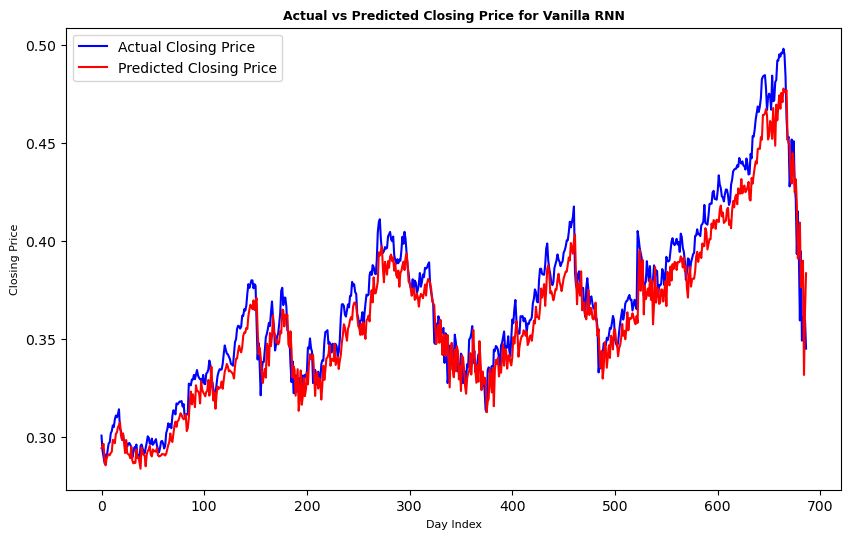

In [8]:
# Plotting actual vs predicted values for Vanilla RNN
plt.figure(figsize=(10, 6))
plt.plot(y_val[:, 3], label='Actual Closing Price', color='blue')
plt.plot(y_val_pred_rnn[:, 3], label='Predicted Closing Price', color='red')
plt.xlabel('Day Index',fontsize=8)
plt.ylabel('Closing Price',fontsize=8)
plt.title('Actual vs Predicted Closing Price for Vanilla RNN',fontsize=9,weight='bold')
plt.legend()
plt.savefig('AP_Vanilla.png', dpi=300, bbox_inches='tight')
plt.show()

### 3. Experiment 1 - LSTM model

In [9]:
# Defining the LSTM model
lstm_model = Sequential()

# Adding an input layer
lstm_model.add(tf.keras.Input(shape=(time_step, X_train.shape[2])))

# Adding an LSTM layer with 50 units
lstm_model.add(LSTM(50, activation='tanh', return_sequences=False))

# Adding a Dropout layer for regularization
lstm_model.add(Dropout(0.2))

# Adding a Dense output layer
lstm_model.add(Dense(X_train.shape[2]))  # Predicting all features

# Compiling the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
lstm_model.summary()

# Training the model
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),callbacks=[early_stopping], verbose=1)

# Predict on the validation set
y_val_pred_lstm = lstm_model.predict(X_val)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,455 (44.75 KB)

 Trainable params: 11,455 (44.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 2.5403e-04
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6885e-04 - val_loss: 1.3397e-04
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0628e-04 - val_loss: 1.5140e-04
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6320e-04 - val_loss: 1.5721e-04
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1932e-04 - val_loss: 1.3523e-04
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9729e-04 - val_loss: 1.5680e-04
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5694e-04 - val_loss: 1.3891e-04
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [10]:
# Evaluate the model with performance metrics for each feature
for i, feature in enumerate(features):
    mae = mean_absolute_error(y_val[:, i], y_val_pred_lstm[:, i])
    mse = np.mean((y_val[:, i] - y_val_pred_lstm[:, i])**2)
    rmse = mse ** 0.5
    print(f"LSTM Validation Metrics for {feature}:")
    print(f"  MAE: {mae}")
    print(f"  RMSE: {rmse}")

LSTM Validation Metrics for Open:
  MAE: 0.009735928910953045
  RMSE: 0.01441305382489942
LSTM Validation Metrics for High:
  MAE: 0.007268454369023814
  RMSE: 0.009418146138411562
LSTM Validation Metrics for Low:
  MAE: 0.00906319937168729
  RMSE: 0.011384312399859922
LSTM Validation Metrics for Close:
  MAE: 0.007904123368455161
  RMSE: 0.011189883736189055
LSTM Validation Metrics for Volume:
  MAE: 0.007726085421316003
  RMSE: 0.010890160637696485


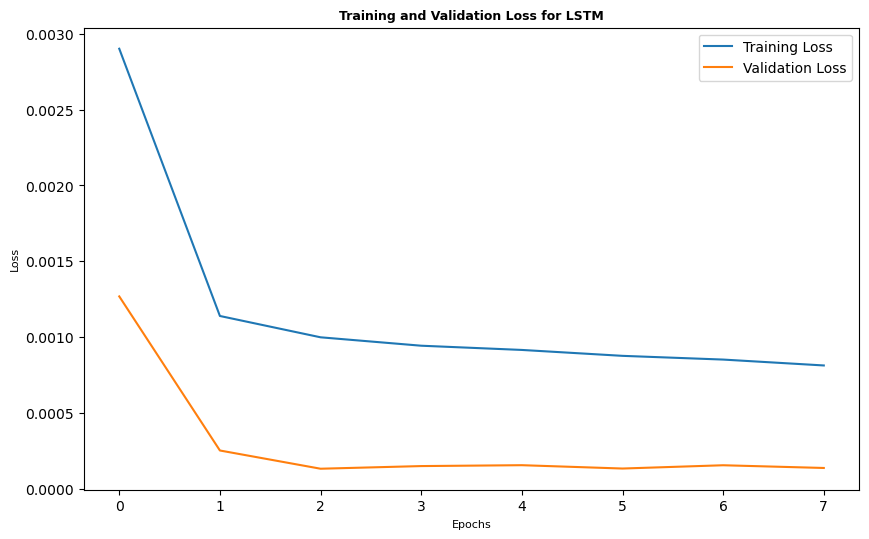

In [11]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs',fontsize=8)
plt.ylabel('Loss',fontsize=8)
plt.title('Training and Validation Loss for LSTM',fontsize=9,weight='bold')
plt.legend()
plt.savefig('Loss-LSTM.png', dpi=300, bbox_inches='tight')
plt.show()

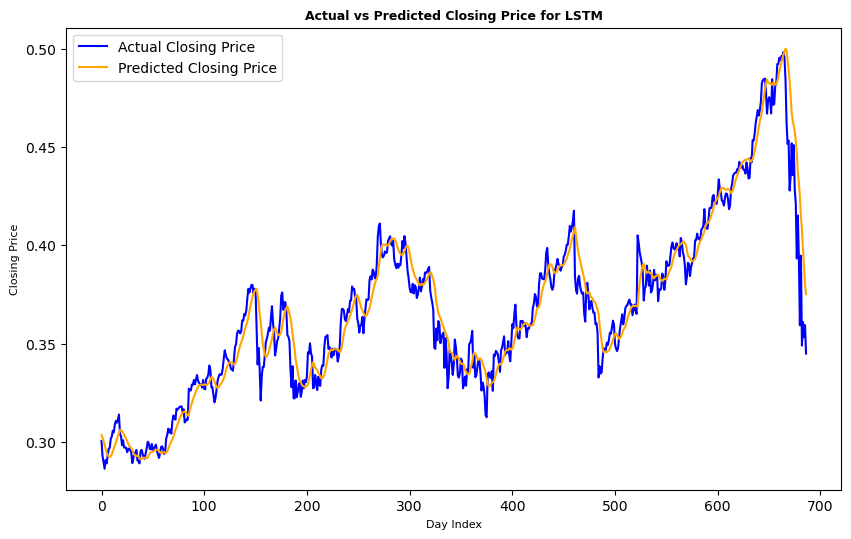

In [12]:
# Plotting actual vs predicted values for LSTM
plt.figure(figsize=(10, 6))
plt.plot(y_val[:, 3], label='Actual Closing Price', color='blue')
plt.plot(y_val_pred_lstm[:, 3], label='Predicted Closing Price', color='orange')
plt.xlabel('Day Index', fontsize=8)
plt.ylabel('Closing Price',fontsize=8)
plt.title('Actual vs Predicted Closing Price for LSTM',fontsize=9,weight='bold')
plt.legend()
plt.savefig('AP-LSTM.png', dpi=300, bbox_inches='tight')
plt.show()

### 4. Experiment 2 - GRU model

In [13]:
# Defining the GRU model
gru_model = Sequential()

# Adding an input layer
gru_model.add(tf.keras.Input(shape=(time_step, X_train.shape[2])))

# Adding a GRU layer with 50 units
gru_model.add(GRU(50, activation='tanh', return_sequences=False))

# Adding a Dropout layer for regularization
gru_model.add(Dropout(0.2))

# Adding a Dense output layer
gru_model.add(Dense(X_train.shape[2]))  # Predicting all features

# Compiling the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
gru_model.summary()

# Training the model
gru_history = gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),callbacks=[early_stopping], verbose=1)

# Predict on the validation set
y_val_pred_gru = gru_model.predict(X_val)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         8,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,805 (34.39 KB)

 Trainable params: 8,805 (34.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0100 - val_loss: 0.0022
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 6.9539e-04
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 4.3771e-04
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9203e-04 - val_loss: 2.2937e-04
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4597e-04 - val_loss: 1.1376e-04
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7914e-04 - val_loss: 1.2797e-04
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6659e-04 - val_loss: 9.2396e-05
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3188e-04 - val_loss: 1.1112e-04
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9524e-04 - val_loss: 1.1910e-04
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8701e-04 - val_loss: 8.3744e-05
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5152e-04 - v

In [14]:
## Evaluate the model with performance metrics for each feature
for i, feature in enumerate(features):
    mae = mean_absolute_error(y_val[:, i], y_val_pred_gru[:, i])
    mse = np.mean((y_val[:, i] - y_val_pred_gru[:, i])**2)
    rmse = mse ** 0.5
    print(f"GRU Validation Metrics for {feature}:")
    print(f"  MAE: {mae}")
    print(f"  RMSE: {rmse}")

GRU Validation Metrics for Open:
  MAE: 0.004951963679047028
  RMSE: 0.007310074677674279
GRU Validation Metrics for High:
  MAE: 0.004772406703864247
  RMSE: 0.0064925991217771074
GRU Validation Metrics for Low:
  MAE: 0.005316385129271137
  RMSE: 0.007743979800194731
GRU Validation Metrics for Close:
  MAE: 0.006016585100108003
  RMSE: 0.008056634183862394
GRU Validation Metrics for Volume:
  MAE: 0.005408138798585455
  RMSE: 0.007887468485514656


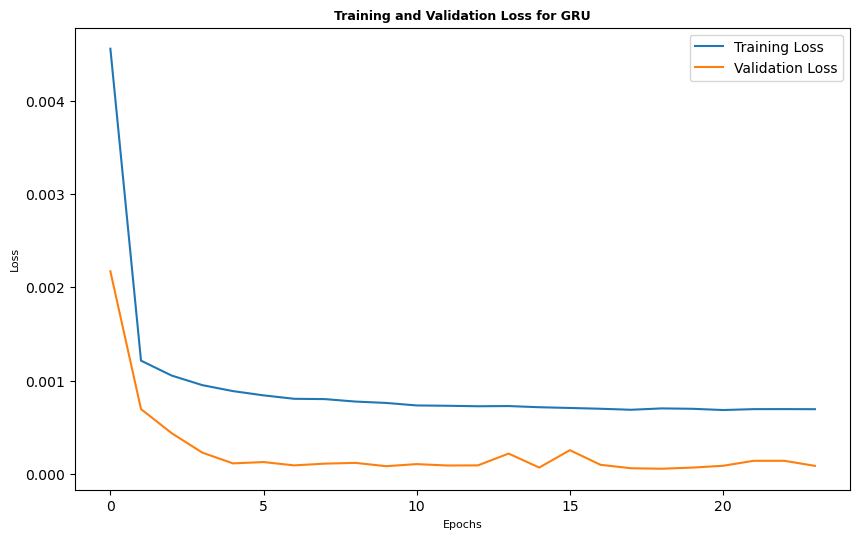

In [15]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(gru_history.history['loss'], label='Training Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs',fontsize=8)
plt.ylabel('Loss',fontsize=8)
plt.title('Training and Validation Loss for GRU',fontsize=9,weight='bold')
plt.legend()
plt.savefig('Loss-GRU.png', dpi=300, bbox_inches='tight')
plt.show()

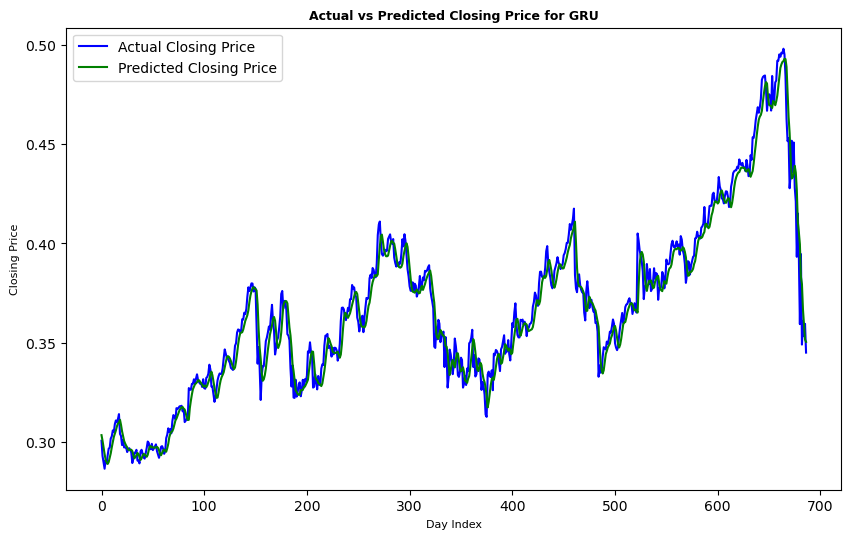

In [16]:
# Plotting actual vs predicted values for GRU
plt.figure(figsize=(10, 6))
plt.plot(y_val[:, 3], label='Actual Closing Price', color='blue')
plt.plot(y_val_pred_gru[:, 3], label='Predicted Closing Price', color='green')
plt.xlabel('Day Index',fontsize=8)
plt.ylabel('Closing Price',fontsize=8)
plt.title('Actual vs Predicted Closing Price for GRU',fontsize=9,weight='bold')
plt.legend()
plt.savefig('AP_GRU.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# Comparison of actual vs predicted performance 

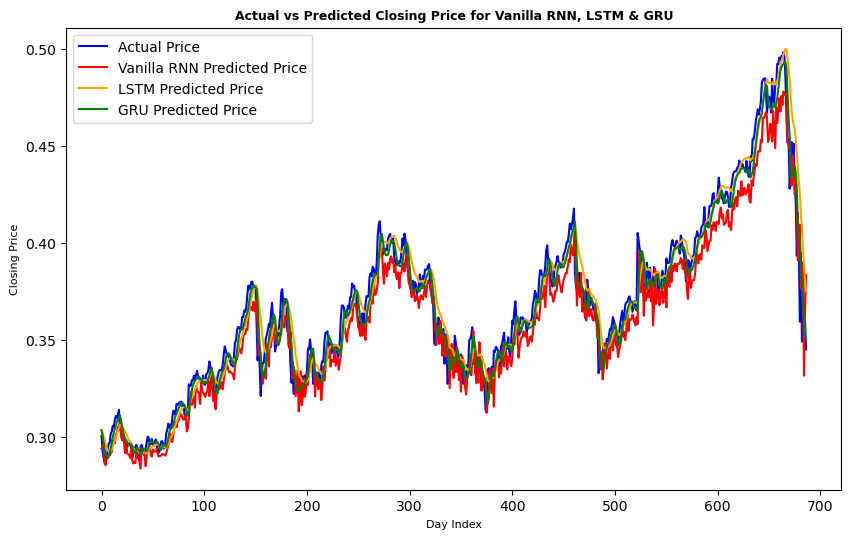

In [18]:
# Plotting actual vs predicted values for Vanilla RNN,LSTM and GRU
plt.figure(figsize=(10, 6))
plt.plot(y_val[:, 3], label='Actual Price', color='blue')
plt.plot(y_val_pred_rnn[:, 3], label='Vanilla RNN Predicted Price', color='red')
plt.plot(y_val_pred_lstm[:, 3], label='LSTM Predicted Price', color='orange')
plt.plot(y_val_pred_gru[:, 3], label='GRU Predicted Price', color='green')
plt.xlabel('Day Index',fontsize=8)
plt.ylabel('Closing Price',fontsize=8)
plt.title('Actual vs Predicted Closing Price for Vanilla RNN, LSTM & GRU',fontsize=9,weight='bold')
plt.legend()
plt.savefig('AP_ALL.png', dpi=300, bbox_inches='tight')
plt.show()

### 5. Experiment 3 - Hyperparameter Optimization

In [19]:
# Hyperparameter optimization using grid search

n_units = [30, 50, 100]  
batch_sizes = [16, 32]  
learning_rates = [0.001, 0.0005, 0.0001] 
dropout_rates = [0.2, 0.3, 0.5]  

param_grid = list(product(n_units, batch_sizes, learning_rates, dropout_rates))

best_val_loss = float('inf')
best_model = None
best_params = None

for model_type in ['RNN', 'LSTM', 'GRU']:
    for n_unit, batch_size, learning_rate, dropout_rate in param_grid:
        print(f"Training {model_type} with units={n_unit}, batch_size={batch_size}, learning_rate={learning_rate}, dropout_rate={dropout_rate}")
        
        # Creating model
        model = Sequential()
        model.add(tf.keras.Input(shape=(time_step, X_train.shape[2])))
        if model_type == 'RNN':
            model.add(SimpleRNN(n_unit, activation='tanh', return_sequences=False))
        elif model_type == 'LSTM':
            model.add(LSTM(n_unit, activation='tanh', return_sequences=False, recurrent_dropout=0.2))
        elif model_type == 'GRU':
            model.add(GRU(n_unit, activation='tanh', return_sequences=False, recurrent_dropout=0.2))
        
        model.add(Dropout(dropout_rate))
        model.add(Dense(X_train.shape[2]))
        model.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mean_squared_error')
        
        # Training the model 
        history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

        # Predict on the validation set
        y_val_pred = model.predict(X_val)
                  
        # Evaluate the model on validation set with performance metrics
        val_loss = model.evaluate(X_val, y_val, verbose=0)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        
        # Print validation metrics
        val_rmse = val_loss ** 0.5
        print(f"Validation RMSE: {val_rmse}")
        print(f"Validation MAE: {val_mae}") 
        
        # Track the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_params = (model_type, n_unit, batch_size, learning_rate, dropout_rate)

Training RNN with units=30, batch_size=16, learning_rate=0.001, dropout_rate=0.2
Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0078 - val_loss: 0.0020
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - val_loss: 8.2626e-04
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6368e-04 - val_loss: 6.5000e-04
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3332e-04 - val_loss: 3.2233e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation RMSE: 0.045017736196416275
Validation MAE: 0.03366942662714618
Training RNN with units=30, batch_size=16, learning_rate=0.001, dropout_rate=0.3
Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0169 - val_loss: 0.0089
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025 - val_loss: 0.0061
Epoch 3/50
201/201 

In [20]:
print("\nBest Model Parameters:")
print(f"Model Type: {best_params[0]}, Units: {best_params[1]}, Batch Size: {best_params[2]}, Learning Rate: {best_params[3]}, Dropout Rate: {best_params[4]}")
print(f"Best Validation Loss: {best_val_loss}")


Best Model Parameters:
Model Type: LSTM, Units: 50, Batch Size: 16, Learning Rate: 0.001, Dropout Rate: 0.2
Best Validation Loss: 0.0003451158700045198


### 6. Retraining the best model on full training data

In [21]:
#retraining on full training data

X_train_full = np.concatenate((X_train, X_val), axis=0)
y_train_full = np.concatenate((y_train, y_val), axis=0)

best_model_type, best_units, best_batch_size, best_lr, best_dropout = best_params

# Recreate the model with the best parameters
final_model = Sequential()
final_model.add(tf.keras.Input(shape=(time_step, X_train_full.shape[2])))

if best_model_type == 'RNN':
    final_model.add(SimpleRNN(best_units, activation='tanh', return_sequences=False))
elif best_model_type == 'LSTM':
    final_model.add(LSTM(best_units, activation='tanh', return_sequences=False,recurrent_dropout=0.2))
elif best_model_type == 'GRU':
    final_model.add(GRU(best_units, activation='tanh', return_sequences=False,recurrent_dropout=0.2))

final_model.add(Dropout(best_dropout))
final_model.add(Dense(X_train.shape[2]))
final_model.compile(optimizer=Adam(learning_rate=best_lr), loss='mean_squared_error')

# Retrain the model on full training data
history = final_model.fit(X_train_full, y_train_full, epochs=50, batch_size=best_batch_size, verbose=1)

Epoch 1/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0063
Epoch 2/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 3/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010
Epoch 4/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.7932e-04
Epoch 5/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.4310e-04
Epoch 6/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.9402e-04
Epoch 7/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4354e-04
Epoch 8/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3296e-04
Epoch 9/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1041e-04
Epoch 10/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0561e-04
Epoch 11/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9780e-04
Epoch 12/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8230e-04
Epoch 13/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9739e-04
Epoch 14/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9756e-04
Epoch 15/50
2

### 7. Test set evaluation

In [22]:
# Test Set Evaluation for All Features
print("Test Set Evaluation for All Features using Best model :")
y_test_pred = final_model.predict(X_test)
for i, feature in enumerate(features):
    mae = mean_absolute_error(y_test[:, i], y_test_pred[:, i])
    mse = np.mean((y_test[:, i] - y_test_pred[:, i])**2)
    rmse = mse ** 0.5
    print(f"{feature}:")
    print(f"  MAE: {mae}")
    print(f"  RMSE: {rmse}")

Test Set Evaluation for All Features using Best model :
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Open:
  MAE: 0.028141740089523914
  RMSE: 0.03473448228508974
High:
  MAE: 0.030513963898479737
  RMSE: 0.03677064214203308
Low:
  MAE: 0.02974856070695876
  RMSE: 0.036560351275520354
Close:
  MAE: 0.03082727758222713
  RMSE: 0.03779260492636334
Volume:
  MAE: 0.011770638050395726
  RMSE: 0.013350609440232242


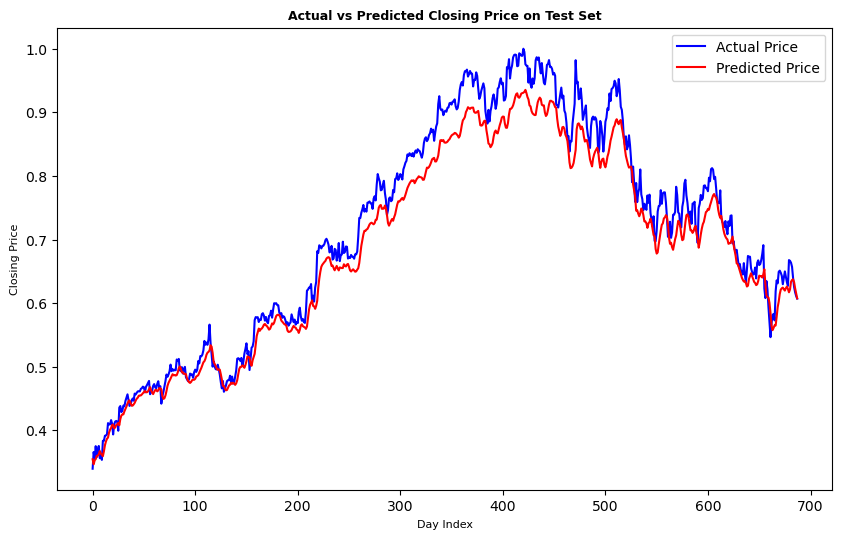

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 3], label='Actual Price', color='blue')
plt.plot(y_test_pred[:, 3], label='Predicted Price', color='red')
plt.xlabel('Day Index',fontsize=8)
plt.ylabel('Closing Price',fontsize=8)
plt.title('Actual vs Predicted Closing Price on Test Set',fontsize=9,weight='bold')
plt.legend()
plt.savefig('AP_Test.png', dpi=300, bbox_inches='tight')
plt.show()

### 8. Forecasting using the best model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Forecasted Values for Next Day :
Open: 92.75905099952105
High: 93.51697702059563
Low: 91.62549517433658
Close: 92.53554101574721
Volume: 7856705.111572571


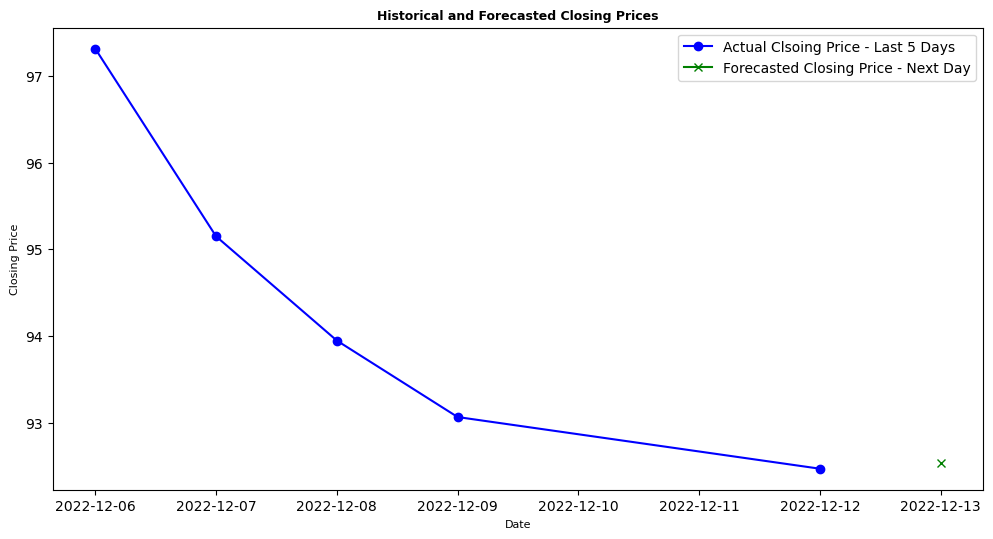

In [24]:
# Prepare input data for forecasting
last_sequence = X_test[-1]  # Getting the last sequence from the test set
last_sequence = last_sequence.reshape((1, time_step, X_train_full.shape[2]))

# Forecast future stock prices for 1 day
n_future_days = 1  # Number of days to forecast
forecast = []

# Inverse transform scaler for forecast
forecast_inverse = []

# Predict the next day
next_price = final_model.predict(last_sequence)  
forecast.append(next_price[0])

# Inverse transform the predicted price to original scale
inverse_price = scaler.inverse_transform([next_price[0]])[0]
forecast_inverse.append(inverse_price)

# Print forecasted values for all features
print("Forecasted Values for Next Day :")
for i, feature in enumerate(features):
    print(f"{feature}: {inverse_price[i]}")

# Plot the forecasted values with actual test data
forecast_dates = pd.concat([dates_test[-5:], dates_test.iloc[[-1]] + pd.DateOffset(1)])

plt.figure(figsize=(12, 6))
y_test_inverse = scaler.inverse_transform(np.hstack([y_test[-5:]]))[:, 3]
plt.plot(forecast_dates[:5], y_test_inverse, label='Actual Clsoing Price - Last 5 Days',marker='o', color='blue')
plt.plot(forecast_dates[-n_future_days:], [x[3] for x in forecast_inverse], label='Forecasted Closing Price - Next Day', marker='x',color='green')
plt.xlabel('Date',fontsize=8)
plt.ylabel('Closing Price',fontsize=8)
plt.title('Historical and Forecasted Closing Prices',fontsize=9,weight='bold')
plt.legend()
plt.savefig('forecast.png', dpi=300, bbox_inches='tight')
plt.show()